In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import pathlib

fig_w,fig_h = 20,10
plt.rcParams['figure.figsize'] = [fig_w,fig_h]
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(os.getcwd())

C:\Ariel\NLP_DNN_course\NLP_course


In [2]:
data_fld = os.path.join('data','mini_data')
mask_fld = os.path.join('data','mini_data','masks')
CLASS_NAMES = [x for x in os.listdir(data_fld)]
IMG_WIDTH, IMG_HEIGHT = 525,350

data_root = pathlib.Path(data_fld)

data_df = pd.read_csv('data/train.csv')
data_df = data_df[data_df['EncodedPixels'].isnull()==False]

print("Labels:", CLASS_NAMES)

Labels: ['Fish', 'Flower', 'Gravel', 'Sugar']


In [3]:
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]

print('Img#',len(all_image_paths))
all_image_paths[:10]

Img# 11836


['data\\mini_data\\Fish\\0011165.jpg',
 'data\\mini_data\\Fish\\002be4f.jpg',
 'data\\mini_data\\Fish\\0031ae9.jpg',
 'data\\mini_data\\Fish\\003994e.jpg',
 'data\\mini_data\\Fish\\006bf7c.jpg',
 'data\\mini_data\\Fish\\006c5a6.jpg',
 'data\\mini_data\\Fish\\008a5ff.jpg',
 'data\\mini_data\\Fish\\009e2f3.jpg',
 'data\\mini_data\\Fish\\00bea06.jpg',
 'data\\mini_data\\Fish\\00dec6a.jpg']

In [4]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['Fish', 'Flower', 'Gravel', 'Sugar']

In [5]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'Fish': 0, 'Flower': 1, 'Gravel': 2, 'Sugar': 3}

In [6]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [7]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return image_rel


In [8]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range

  return image

def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

Text(0.5, 1.0, 'Fish')

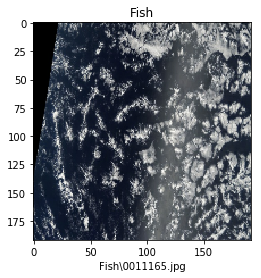

In [9]:
import matplotlib.pyplot as plt

img_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(img_path))
plt.title(label_names[label].title())

In [10]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
print('shape:',repr(path_ds.output_shapes))
print('type:',path_ds.output_types)
print(path_ds)

W1121 12:51:07.262484 15104 deprecation.py:323] From <ipython-input-10-ee80f851a20a>:2: DatasetV1.output_shapes (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
W1121 12:51:07.263482 15104 deprecation.py:323] From <ipython-input-10-ee80f851a20a>:3: DatasetV1.output_types (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.


shape: TensorShape([])
type: <dtype: 'string'>
<DatasetV1Adapter shapes: (), types: tf.string>


In [11]:
image_ds = path_ds.map(load_and_preprocess_image,num_parallel_calls=AUTOTUNE)

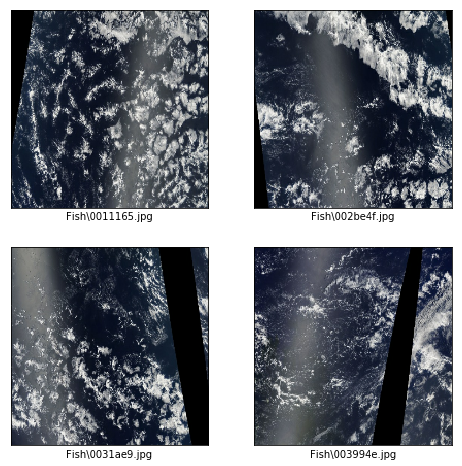

In [12]:
plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
    plt.subplot(2,2,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(caption_image(all_image_paths[n]))
plt.show()

In [13]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

In [26]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
image_count = len(all_image_paths)
ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [22]:
## Build Cnn

def create_placeholders(n_H0,n_W0,n_C0,n_y):
    X = tf.placeholder(tf.float32,[None,n_H0,n_W0,n_C0])
    Y = tf.placeholder(tf.float32,[None,n_y])
    return X,Y

def init_params():
    tf.set_random_seed(42)
    
    W1 = tf.get_variable("W1",[4,4,3,8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2",[2,2,8,16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    
    parameters = {"W1":W1,
                 "W2":W2}
    
    return parameters

def forward_propagation(X,params):
    
    # Retrive the parameters from the dict
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # Conv2d
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME')
    
    #RELU
    A1 = tf.nn.relu(Z1)
    
    # MAXPOOL
    P1 = tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding='SAME')
    
    # Conv2d
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding='SAME')
    
    #RELU
    A2 = tf.nn.relu(Z2)
    
    # MAXPOOL
    P2 = tf.nn.max_pool(A2,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')
    
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    
    Z3 = tf.contrib.layers.fully_connected(P2,4,activation_fn=None)
    
    return Z3

def compute_cost(Z3,Y):
    cost = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits_v2(logits=Z3,labels=Y)
    )
    
    return cost

def model(X_train,Y_train,X_test,Y_test,learning_rate=0.009,
         num_epochs=400,minibatch_size=64,print_cost=True):
    ops.reset_default_graph()
    tf.set_random_seed(42)
    seed = 3
    (m,n_H0,n_W0,nC0) = X_train.shape
    n_y = Y_train.shape[1]
    costs=[]
    
    X,Y = create_placeholders(n_H0,n_W0,n_C0,n_y)
    
    parameters = init_params()
    
    
    Z3 = forward_propagation(X,parameters)
    
    cost = compute_cost(Z3,Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        ses.run(init)
        
        for epoch in range(num_epochs):
            
            minibatch_cost = 0.
            num_minibatches = int(m/minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train,Y_train,minibatch_size,seed)
            
            for minibatch in minibatches:
                
                (minibatch_X,minibatch_Y) = minibatch
                
                _,temp_cost = sess.run([optimizer,cost],feed_dict=
                                      {X:minibatch_X,Y:minibatch_Y})
                minibatch_cost +=temp_cost/num_minibatches
                
                
            # Epoch prints
            if print_cost == True and epoch % 100 ==0:
                print("Cost after epoch %i:, %f"%(epoch,minibatch_cost))
            if print_cost == True and epoch % 1 ==0:
                costs.append(minibatch_cost)
            
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    # Calculate the correct predictions
    predict_op = tf.argmax(Z3, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print(accuracy)
    train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
    test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)

    return train_accuracy, test_accuracy, parameters
     

In [30]:
print(ds)

# train_ac,test_ac,params = model(X_train,Y_train,X_test,Y_test)
# train_ac,test_ac

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>


<bound method DatasetV2.batch of <DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>>